## Importar Bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import seaborn as sns

%matplotlib inline

import spacy.cli
spacy.cli.download("pt_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
import pt_core_news_sm

spc_pt = pt_core_news_sm.load()

### Carregar o Dataset

In [3]:
data = pd.read_csv('olist_order_reviews_dataset.csv')

In [4]:
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


### Limpeza dos dados

In [5]:
data.drop(['order_id', 'review_creation_date', 'review_answer_timestamp'], inplace=True, axis=1)

In [6]:
data

,review_id,review_score,review_comment_title,review_comment_message
0,7bc2406110b926393aa56f80a40eba40,4,NaN,NaN
1,80e641a11e56f04c1ad469d5645fdfde,5,NaN,NaN
2,228ce5500dc1d8e020d8d1322874b6f0,5,NaN,NaN
3,e64fb393e7b32834bb789ff8bb30750e,5,NaN,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,NaN,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,5,NaN,NaN
99996,b3de70c89b1510c4cd3d0649fd302472,5,NaN,"Excelente mochila, entrega super rápida. Super..."
99997,1adeb9d84d72fe4e337617733eb85149,4,NaN,NaN
99998,be360f18f5df1e0541061c87021e6d93,1,NaN,Solicitei a compra de uma capa de retrovisor c...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   review_id               100000 non-null  object
 1   review_score            100000 non-null  int64 
 2   review_comment_title    11715 non-null   object
 3   review_comment_message  41753 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


### Verificando duplicados

In [26]:
# ((data.duplicated()/data.shape[0]).sort_values(ascending=False))*100
(data.duplicated()/data.shape[0]*100).sort_values(ascending=False)

22324    0.001
97035    0.001
89893    0.001
63033    0.001
77518    0.001
         ...  
66406    0.000
66407    0.000
66408    0.000
66409    0.000
0        0.000
Length: 100000, dtype: float64

In [10]:
duplicados = round(sum(data.duplicated("review_id"))/(len(data))*100, 2)
print(f"Reviews com id duplicados: {duplicados}%.")

Reviews com id duplicados: 0.83%.


In [35]:
data[data.duplicated("review_id", keep=False)].sort_values(by="review_id")

,review_id,review_score,review_comment_title,review_comment_message
47045,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
30062,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
63695,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
91399,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
57727,0174caf0ee5964646040cd94e15ac95e,1,NaN,Produto entregue dentro de embalagem do fornec...
...,...,...,...,...
40677,fe5c833752953fed3209646f1f63b53c,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ..."
7924,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
83183,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
1997,ffb8cff872a625632ac983eb1f88843c,3,NaN,NaN


In [36]:
data.drop_duplicates("review_id", inplace=True)

In [13]:
data.fillna('', inplace=True) # para não termos problemas com nulos na concatenação

In [14]:
# concatenando duas colunas
data['review'] = data['review_comment_title'] + ' ' + data['review_comment_message']

In [44]:
data

,review_id,review_score,review_comment_title,review_comment_message,review
0,7bc2406110b926393aa56f80a40eba40,4,,,
1,80e641a11e56f04c1ad469d5645fdfde,5,,,
2,228ce5500dc1d8e020d8d1322874b6f0,5,,,
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,5,,,
99996,b3de70c89b1510c4cd3d0649fd302472,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe..."
99997,1adeb9d84d72fe4e337617733eb85149,4,,,
99998,be360f18f5df1e0541061c87021e6d93,1,,Solicitei a compra de uma capa de retrovisor c...,Solicitei a compra de uma capa de retrovisor ...


In [16]:
# removendo entradas sem texto
data = data[data['review']!=' ']

In [99]:
data

,review_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."
...,...,...,...,...,...
99983,df5fae90e85354241d5d64a8955b2b09,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...
99990,a709d176f59bc3af77f4149c96bae357,3,,"O produto não foi enviado com NF, não existe v...","O produto não foi enviado com NF, não existe ..."
99996,b3de70c89b1510c4cd3d0649fd302472,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe..."
99998,be360f18f5df1e0541061c87021e6d93,1,,Solicitei a compra de uma capa de retrovisor c...,Solicitei a compra de uma capa de retrovisor ...


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43152 entries, 3 to 99999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               43152 non-null  object
 1   review_score            43152 non-null  int64 
 2   review_comment_title    43152 non-null  object
 3   review_comment_message  43152 non-null  object
 4   review                  43152 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [18]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."


In [19]:
data["review_score"].value_counts()

5    21762
1     9153
4     6296
3     3721
2     2220
Name: review_score, dtype: int64

In [20]:
labels = []

for score in data['review_score']:
    if score > 3:
        labels.append(1)
    else:
        labels.append(0)

data['label'] = labels

<ipython-input-20-2f0ddea54311>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = labels


In [21]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1


C:\Users\andre.paes\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


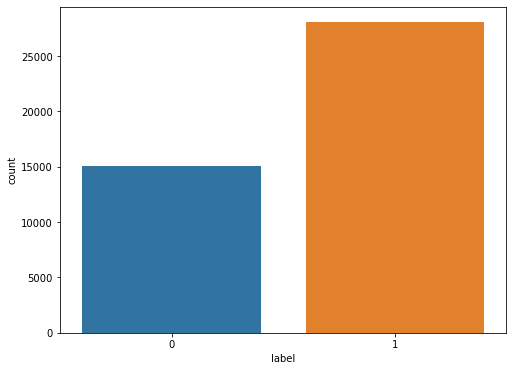

In [22]:
plt.figure(figsize=(8,6))
sns.countplot(data['label'])
plt.show()

#### Há bem mais reviews positivas do que negativas

### Pré-processamento do texto

In [23]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre.paes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [24]:
stopwords_pt = stopwords.words("portuguese")

In [25]:
stopwords_pt

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

### Obs. Palavras como 'não' e 'nem' podem ser importantes na análise de sentimentos, por isso vamos tirá-las da lista de stopwords.

In [26]:
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [27]:
def limpa_texto(texto):
    '''(str) -> str
    Essa função recebe uma string, deixa tudo em minúsculo, filtra apenas letras,
    retira stopwords, lemmatiza e retorna a string resultante.'''
    
    texto = texto.lower()
    
    texto = re.sub(r"[\W\d_]+", " ", texto)
    
    texto = [pal for pal in texto.split() if pal not in stopwords_pt]
    
    spc_texto = spc_pt(" ".join(texto))
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]
    
    return " ".join(tokens)

In [28]:
data['review'] = data['review'].apply(limpa_texto)

<ipython-input-28-37e246982738>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data['review'].apply(limpa_texto)


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43152 entries, 3 to 99999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               43152 non-null  object
 1   review_score            43152 non-null  int64 
 2   review_comment_title    43152 non-null  object
 3   review_comment_message  43152 non-null  object
 4   review                  43152 non-null  object
 5   label                   43152 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.6+ MB


In [30]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,receber bem antar prazo estipular,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,parabém loja lannister adorar comprar internet...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendar aparelhar eficiente site marcar apa...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom,1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",super recomendar vendedor confiável produto ok...,1


In [31]:
data[data['review']=='']

,review_id,review_score,review_comment_title,review_comment_message,review,label
299,2b4a570df87cd63b232272dd9dcac0cf,5,,A,,1
465,3140a4eb146655fe104d54d385f9e9a0,5,,10,,1
585,3814f35a6ebd64d27e2130f30ec05255,4,5,,,1
600,057c9a1e8e767d8bf6fa59ac43a82435,4,4,,,1
944,8f965d010b3119d9962e091de3425fb9,4,,*******************,,1
...,...,...,...,...,...,...
95522,014f70270fa59804f14eb3df2ca690d2,5,,........................,,1
97525,47850e2adbd18f61f2af4af9b7656198,5,,👍🏻👌🏻👏🏻,,1
98206,e47fd0401fce7a7b6283da2a5a8ba563,5,10,,,1
98800,f004d8b3a2ff22e3c030285842cf629a,5,*****,,,1


In [32]:
data = data[data['review']!= '']

In [33]:
data[data['review']=='']

,review_id,review_score,review_comment_title,review_comment_message,review,label


In [ ]:
# Verificamos que não existem mais informações faltantes

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42891 entries, 3 to 99999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42891 non-null  object
 1   review_score            42891 non-null  int64 
 2   review_comment_title    42891 non-null  object
 3   review_comment_message  42891 non-null  object
 4   review                  42891 non-null  object
 5   label                   42891 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


In [35]:
data.to_csv('olist_preprocessado.csv', index=False, columns=['review_id', 'review', 'label'])

## Feature Extraction

In [2]:
data = pd.read_csv('olist_preprocessado.csv')

NameError: name 'pd' is not defined

In [7]:
# Vamos testar dois métodos: Com Bag of Words com um vetor de componentes binários ou TF-ID.
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
# Importando o CauntVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
# Instanciando o CountVectorizer, binary=True faz a codificaçã binária
vectorizer = CountVectorizer(binary=True, max_features=5000)

In [10]:
texto = data['review']

In [11]:
# Vetorizando o texto
X_bow = vectorizer.fit_transform(texto)

In [12]:
X_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [13]:
print(X_bow.shape, type(X_bow))

(42891, 5000) <class 'scipy.sparse.csr.csr_matrix'>


## Com TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
# Instanciando o TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)

In [16]:
# Vetorizando
X_Tfidf = tfidf_vect.fit_transform(texto)

In [17]:
print(X_Tfidf)

  (0, 1883)	0.6933181141682138
  (0, 3677)	0.3055742580640303
  (0, 269)	0.3527978440552724
  (0, 578)	0.4278176238568358
  (0, 3994)	0.3441513145729538
  (1, 3873)	0.4786581907792164
  (1, 2060)	0.30331638770034963
  (1, 4625)	0.21217955720139903
  (1, 3846)	0.32360917602377554
  (1, 4325)	0.3310862822237056
  (1, 2564)	0.31195347329730727
  (1, 1018)	0.12833643775746337
  (1, 85)	0.2162699943274212
  (1, 2675)	0.20439357493414326
  (1, 2783)	0.16829338052888398
  (1, 3391)	0.43458830997345477
  (2, 4850)	0.1814206675408719
  (2, 1179)	0.16518292044930644
  (2, 444)	0.2956900187304881
  (2, 3185)	0.2343070984405629
  (2, 3348)	0.14545802024366608
  (2, 877)	0.09498563224213537
  (2, 2445)	0.2956900187304881
  (2, 2887)	0.4008556875171997
  (2, 4404)	0.14892187284016076
  :	:
  (42889, 3748)	0.29950777315704524
  (42889, 837)	0.30788927034916136
  (42889, 795)	0.20543726981504243
  (42889, 2665)	0.46340701576932003
  (42889, 1499)	0.18812067491300652
  (42889, 3009)	0.1892569865132692


## Modelos

### Primeiro é preciso dividir os dados em base de treino(70%) e teste(30%).

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, data['label'], test_size=0.30, random_state=1)

In [20]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_Tfidf, data['label'], test_size=0.30, random_state=1)

#### Importando as métricas que serão usadas para avaliar cada modelo

In [21]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

In [22]:
def mostra_metricas(y_true, y_pred):
    '''
    Função que recebe o y real, o y predito e apresenta as principais métricas
    '''
    print('Acurácia:', accuracy_score(y_true, y_pred))
    print('\nAUROC:', roc_auc_score(y_true, y_pred))
    print('\nF1-Score:', f1_score(y_true, y_pred, average='weighted'))
    print('\nMatriz de Confusão:')
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
    plt.show()

## Regressão Logística

### Texto vetorizado com Bag of Words

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
# Instanciando a LogisticRegression
reglog = LogisticRegression()

In [25]:
# Aplicando o modelo
reglog.fit(X1_train, y1_train)

C:\Users\andre.paes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
y1_reglog_pred = reglog.predict(X1_test)

### Vamos agora analisar as Métricas

Acurácia: 0.8981193658688219

AUROC: 0.8845532887915784

F1-Score: 0.897680831890705

Matriz de Confusão:


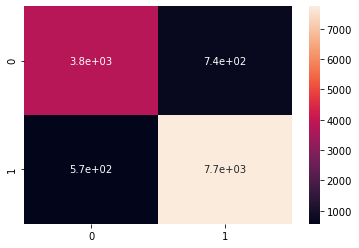

In [27]:
mostra_metricas(y1_test, y1_reglog_pred)

### Texto vetorizado com TF-IDF

In [28]:
reglog2 = LogisticRegression()

In [29]:
reglog2.fit(X2_train, y2_train)

C:\Users\andre.paes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
y2_reglog_pred = reglog2.predict(X2_test)

Acurácia: 0.9024712465029531

AUROC: 0.8933739261246474

F1-Score: 0.902468828973133

Matriz de Confusão:


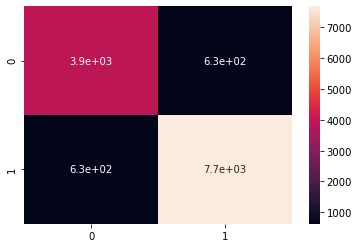

In [31]:
mostra_metricas(y2_test, y2_reglog_pred)

#### A diferença do desempenho entre os dois modelos de feature extraction foi bem pouca, mas os resultados das métricas apontam que foi melhor com o TF-IDF.

## Naive Bayes Multinomial

### BoW

In [32]:
from sklearn.naive_bayes import MultinomialNB

In [33]:
nb1 = MultinomialNB()

In [34]:
nb1.fit(X1_train.toarray(), y1_train)

MultinomialNB()

In [35]:
y1_gnb_pred = nb1.predict(X1_test.toarray())

Acurácia: 0.8901927261423687

AUROC: 0.8840171316798539

F1-Score: 0.8906136689731637

Matriz de Confusão:


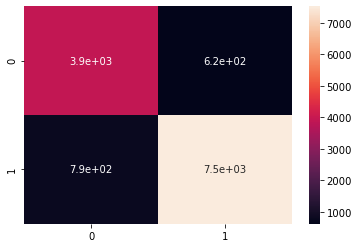

In [36]:
mostra_metricas(y1_test, y1_gnb_pred)

### TF-IDF

In [37]:
nb2 = MultinomialNB()

In [38]:
nb2.fit(X2_train.toarray(), y2_train)

MultinomialNB()

In [39]:
y2_gnb_pred = nb2.predict(X2_test.toarray())

Acurácia: 0.8901150139881877

AUROC: 0.8825197282502492

F1-Score: 0.8903940519280684

Matriz de Confusão:


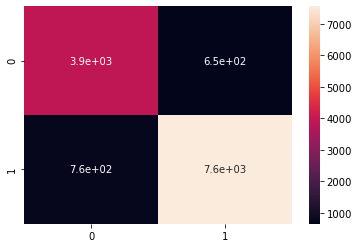

In [40]:
mostra_metricas(y2_test, y2_gnb_pred)

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

### BoW

In [42]:
rf1 = RandomForestClassifier()

In [43]:
rf1.fit(X1_train, y1_train)

RandomForestClassifier()

In [44]:
y1_dt_pred = rf1.predict(X1_test)

Acurácia: 0.8976530929437364

AUROC: 0.8903377707951847

F1-Score: 0.8978725035515813

Matriz de Confusão:


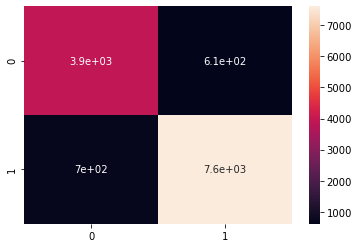

In [45]:
mostra_metricas(y1_test, y1_dt_pred)

In [46]:
rf2 = RandomForestClassifier()

In [47]:
rf2.fit(X2_train, y2_train)

RandomForestClassifier()

In [48]:
y2_dt_pred = rf2.predict(X2_test)

Acurácia: 0.8937674852346907

AUROC: 0.8882713506298261

F1-Score: 0.8942076885722141

Matriz de Confusão:


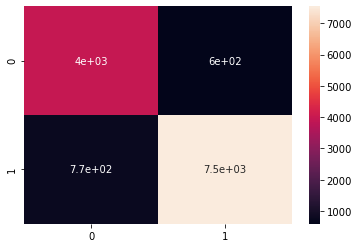

In [49]:
mostra_metricas(y2_test, y2_dt_pred)

## Resultados

#### Para todos os modelos, a diferença entre usar o Bag of Wors ou TF-IDF foi bem pouca. Os modelos apresentaram melhores rmétricas com TF-IDF, com exceção do Naive Bayes. O mehor modelo foi a Regressão Logística (com TF-IDF), com acurácia e F1 de 90% e AUROC de 89% (arredondando). Vamos testá-lo com um novo texto.


In [50]:
def nova_predicao(texto):
    '''
    Função que recebe uma string e printa a predição feita pelo modelo reglog2
    '''
    texto_vetorizado = tfidf_vect.transform([texto])
    pred = reglog2.predict(texto_vetorizado)
    
    if pred ==0:
        print("Essa é uma review negativa")
    else:
        print("Essa é uma review positiva")
        

In [51]:
nova_predicao("Demorou muito não gostei")

Essa é uma review negativa


In [52]:
nova_predicao("Achei cheirosinho")

Essa é uma review positiva


In [53]:
nova_predicao("Nossa que produto ruim é esse parece que encontrei no lixo")

Essa é uma review negativa


In [54]:
nova_predicao("Gostei")

Essa é uma review positiva


In [55]:
nova_predicao("Não gostei")

Essa é uma review negativa


In [60]:
nova_predicao("Lugar ruim")

Essa é uma review negativa
